In [40]:
import torch
import torchvision
import os
import numpy as np

In [41]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print('Model is training on Cuda')
else:
    print('Model is training on CPU')

Model is training on Cuda


In [152]:
data_dir = '../car-damage-detective/car-damage-dataset/data3a/'
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(30),
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])


train_data = torchvision.datasets.ImageFolder(data_dir + 'training/', transform = transform)
valid_data  = torchvision.datasets.ImageFolder(data_dir + 'validation/' , transform = transform)

Batch_Size = 128

train_iterator = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size = Batch_Size)
valid_iterator = torch.utils.data.DataLoader(valid_data, shuffle = True, batch_size = Batch_Size)

In [153]:
device = torch.device('cuda')

In [154]:
model = torchvision.models.resnet18(pretrained=True)
model = model.to(device)

In [155]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [156]:
# Freeze the wights of the pretrained model
for par in model.parameters():
    par.requires_grad = False

In [157]:
model.fc = torch.nn.Linear(in_features=512, out_features=3).to(device)

In [158]:
Loss_Fnc = torch.nn.CrossEntropyLoss()
Optimizer = torch.optim.Adam(model.parameters())

In [159]:
def accuracy(fx, y):
    preds = fx.max(1, keepdim = True)[1]
    corrects = preds.eq(y.view_as(preds)).sum()
    accurate = corrects.float() / preds.shape[0]
    return accurate

In [160]:
def train(model, device, iterator, optimizer, loss_fnc):
    loss_epoch = 0
    acc_epoch  = 0
    
    model.train()
    
    for (x,y) in iterator:
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        fx = model(x)
        
        Loss = loss_fnc(fx,y)
        Acc = accuracy(fx,y)
        
        Loss.backward()
        
        optimizer.step()
        
        loss_epoch += Loss.item()
        acc_epoch  += Acc.item()
    
    return loss_epoch / len(iterator) , acc_epoch / len(iterator)

In [161]:
def evaluate(model, device, iterator, loss_fnc):
    loss_epoch = 0
    acc_epoch  = 0
    
    model.eval()
    
    with torch.no_grad():
        for (x,y) in iterator:
            x = x.to(device)
            y = y.to(device)
            
            fx = model(x)
            
            Loss = loss_fnc(fx,y)
            
            Acc = accuracy(fx, y)
            
            loss_epoch += Loss.item()
            acc_epoch  += Acc.item()
    return loss_epoch / len(iterator), acc_epoch / len(iterator)

In [162]:
Epochs = 100
Model_Path = os.path.join(data_dir , 'resnet18_data3a.pt')
best_valid_loss = float('inf')

In [163]:
history = [TL,TA,VL,VA]

In [164]:
TL = []
TA = []
VL = []
VA = []
times = []
for epoch in range(Epochs):
    times.append(epoch)
    train_loss, train_acc = train(model, device, train_iterator, Optimizer, Loss_Fnc)
    TL.append(train_loss)
    TA.append(train_acc)
    val_loss, val_acc = evaluate(model, device, valid_iterator, Loss_Fnc)
    VL.append(val_loss)
    VA.append(val_acc)
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), Model_Path)
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:05.2f}% | Val. Loss: {val_loss:.3f} | Val. Acc: {val_acc*100:05.2f}% |')    

| Epoch: 01 | Train Loss: 1.120 | Train Acc: 40.39% | Val. Loss: 1.126 | Val. Acc: 40.11% |
| Epoch: 02 | Train Loss: 1.032 | Train Acc: 45.77% | Val. Loss: 1.002 | Val. Acc: 50.58% |
| Epoch: 03 | Train Loss: 0.941 | Train Acc: 56.26% | Val. Loss: 0.944 | Val. Acc: 56.80% |
| Epoch: 04 | Train Loss: 0.899 | Train Acc: 57.71% | Val. Loss: 0.935 | Val. Acc: 56.40% |
| Epoch: 05 | Train Loss: 0.856 | Train Acc: 62.14% | Val. Loss: 0.895 | Val. Acc: 59.95% |
| Epoch: 06 | Train Loss: 0.838 | Train Acc: 63.17% | Val. Loss: 0.902 | Val. Acc: 54.90% |
| Epoch: 07 | Train Loss: 0.816 | Train Acc: 63.52% | Val. Loss: 0.861 | Val. Acc: 57.21% |
| Epoch: 08 | Train Loss: 0.796 | Train Acc: 64.93% | Val. Loss: 0.878 | Val. Acc: 59.93% |
| Epoch: 09 | Train Loss: 0.794 | Train Acc: 64.82% | Val. Loss: 0.831 | Val. Acc: 56.81% |
| Epoch: 10 | Train Loss: 0.797 | Train Acc: 63.04% | Val. Loss: 0.817 | Val. Acc: 65.35% |
| Epoch: 11 | Train Loss: 0.766 | Train Acc: 66.63% | Val. Loss: 0.785 | Val. Ac

| Epoch: 91 | Train Loss: 0.636 | Train Acc: 74.02% | Val. Loss: 0.793 | Val. Acc: 65.34% |
| Epoch: 92 | Train Loss: 0.596 | Train Acc: 74.22% | Val. Loss: 0.707 | Val. Acc: 69.60% |
| Epoch: 93 | Train Loss: 0.623 | Train Acc: 74.25% | Val. Loss: 0.777 | Val. Acc: 66.14% |
| Epoch: 94 | Train Loss: 0.621 | Train Acc: 74.01% | Val. Loss: 0.815 | Val. Acc: 64.95% |
| Epoch: 95 | Train Loss: 0.609 | Train Acc: 75.31% | Val. Loss: 0.849 | Val. Acc: 62.25% |
| Epoch: 96 | Train Loss: 0.609 | Train Acc: 73.99% | Val. Loss: 0.882 | Val. Acc: 56.44% |
| Epoch: 97 | Train Loss: 0.613 | Train Acc: 73.25% | Val. Loss: 0.843 | Val. Acc: 62.25% |
| Epoch: 98 | Train Loss: 0.613 | Train Acc: 74.77% | Val. Loss: 0.783 | Val. Acc: 66.14% |
| Epoch: 99 | Train Loss: 0.611 | Train Acc: 74.11% | Val. Loss: 0.836 | Val. Acc: 64.18% |
| Epoch: 100 | Train Loss: 0.619 | Train Acc: 75.20% | Val. Loss: 0.803 | Val. Acc: 61.47% |


In [167]:
model.load_state_dict(torch.load(Model_Path))

<All keys matched successfully>

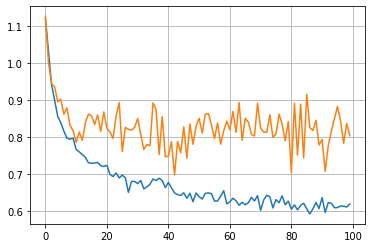

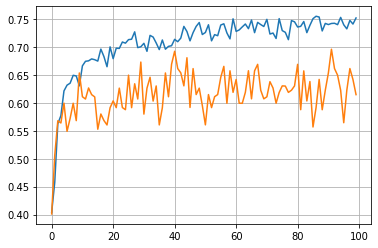

In [168]:
plt.plot(times,TL)
plt.plot(times,VL)
plt.grid(True)
plt.show()
plt.plot(times,TA)
plt.plot(times,VA)
plt.grid(True)
plt.show()

In [169]:
test_loss, test_acc = evaluate(model, device, valid_iterator, Loss_Fnc)

In [170]:
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:05.2f}% |')

| Test Loss: 0.844 | Test Acc: 61.08% |


In [88]:
test_transforms = torchvision.transforms.Compose([torchvision.transforms.Resize(255),
                                      torchvision.transforms.CenterCrop(224),
                                      torchvision.transforms.ToTensor(),
                                      torchvision.transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])

In [89]:
from PIL import Image

In [90]:
def predict(image):
    image = Image.open(image)
    image = test_transforms(image).float()
    image = image.unsqueeze(0)
    image = image.cuda()
    return image

In [103]:
img = model(predict('./test/images.jpeg'))

In [104]:
p = img.max(1, keepdim=True)[1]

In [105]:
t = ['damaged','Non_damaged']

In [106]:
t[p[0]]

'damaged'

In [107]:
print(p)

tensor([[0]], device='cuda:0')


In [31]:
import matplotlib.pyplot as plt